# 11/14/24

Adding anomalous diffusion and fitting as if Gaussian to see if there is clear difference...

See notebook

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr,shapiro,f_oneway, ranksums
from scipy.special import stdtr
import csv
import pandas as pd

from scipy.integrate import quad
import sys 
import os
#sys.path.append(os.path.abspath("/Users/neuroimaging/Desktop/MR-code/Python_Code"))

#from ML_UsefulFunctions import *
#from KidneyROIAnalyses import *

from scipy import special

from scipy.integrate import tplquad

pd.options.display.float_format = '{:.3f}'.format


from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.simplefilter("ignore")


from EllipsoidalSimulationCode import *

from statistics import mean


def func(x,m,b):
    return m*x + b

In [4]:
def triexp_func(b, frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow):
    Data = frac_slow*np.exp(-b*diff_slow)+frac_med*np.exp(-b*diff_med)+frac_fast*np.exp(-b*diff_fast)
    normal = frac_slow+frac_med+frac_fast
    return Data/normal


## note here that diff_slow should be diff**gamma. instead it isn't. so it's slightly different. 

def anomalous_triexp_func(b, frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow, gamma_fast, gamma_med, gamma_slow):
    Data = frac_slow*np.exp(-(b**gamma_slow)*diff_slow)+frac_med*np.exp(-(b**gamma_med)*diff_med)+frac_fast*np.exp(-(b**gamma_fast)*diff_fast)
    normal = frac_slow+frac_med+frac_fast
    return Data/normal




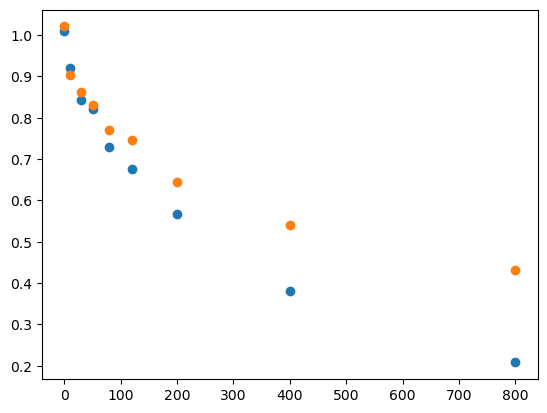

In [5]:
#Diffusion Parameters (Baseline)
diff_fast   = 0.180
diff_med    = 0.0058 #[0.006 0.007 0.008 0.009 0.010];
diff_slow   = 0.0015
frac_fast   = 0.10
frac_med    = 0.30
frac_slow   = 0.60

gamma_fast=2
gamma_med=1
gamma_slow=0.85

#hypothetical for the moment
b_values9 = np.array([0,10,30,50,80,120,200,400,800])
#b_values = np.array([0,10,30,50,80,120,200,400,600,800,1000,1200, 1500]) # just large range 13 b values 0 - 1500

b_values11 = np.array([0,10,30,50,80,120,200,400,800, 1100, 1380]) # medium range 11 b values 0 - 1380


 
#SI = triexp_func(b_values11,frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow)
SI_9  = triexp_func(b_values9,frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow)
SI_noise9 = NoiseRice(SI_9, .02) # with SNR = 50

SI_9_anomalous  = anomalous_triexp_func(b_values9,frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow,gamma_fast, gamma_med, gamma_slow)
SI_noise9_anomalous = NoiseRice(SI_9_anomalous, .02) # with SNR = 50


pl.scatter(b_values9, SI_noise9,label='Assumed Gaussian')
pl.scatter(b_values9, SI_noise9_anomalous, label = 'Anomalous')
pl.show()


# simulations

In [6]:
#Rician noise check

#SNR = 1, sigma = 1
#SNR = 10, sigma = .1
#SNR = 20, sigma = .045
#SNR = 50, sigma = .02
#SNR = 75, sigma = .013
#SNR = 100, sigma = .01
#SNR = 125, sigma = .008
#SNR = 150, sigma = .0065
def NoiseRice(I,SNR): # noise with rician distribution
    N = [] 
    sigma = 1/SNR
    #v = .79 # calculated from images on 6/11/19
    #sigma = .013 #(std of noise measured!)
    #v = 0.00434 #scaled = .79/182
    v = .005816 #scaled 6/27/19
    b = v/sigma
    r = rice.rvs(b, scale = sigma, size=len(I))
    for i in range(0,len(I)):
        N.append(I[i] +r[i]) #SNR = 1,10,22,100,150,inf
    return N

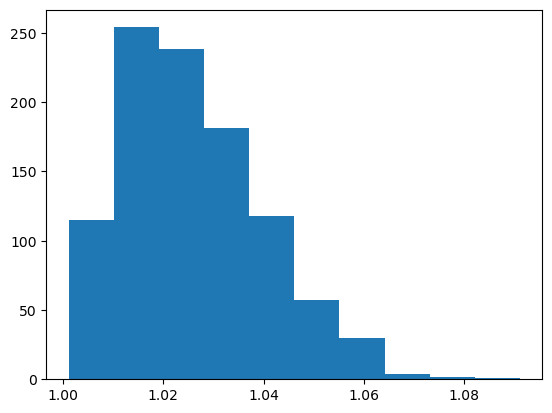

48.44095769077781


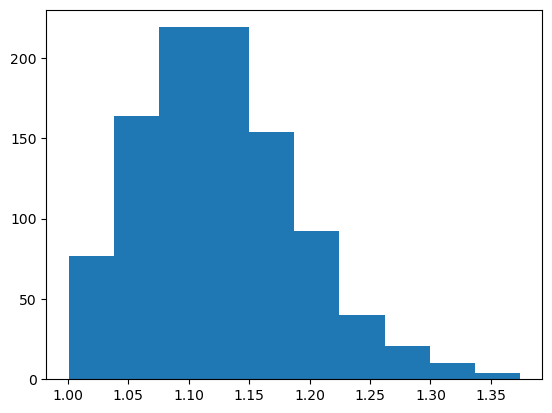

11.238354555557


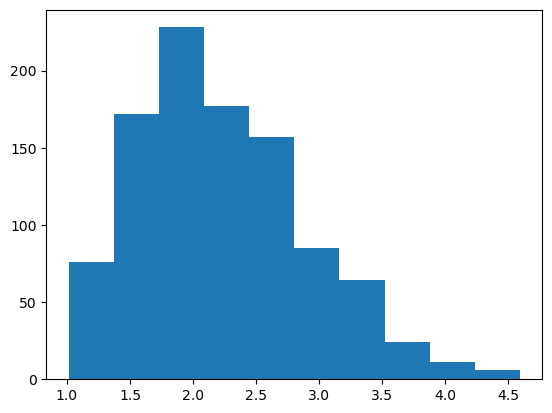

2.2287482773978873


In [7]:
I = np.zeros(1000)+1
check=NoiseRice(I,50)

pl.hist(check)
pl.show()
print(0.66*np.mean(check)/np.std(check)) 
# multiplied by 0.66 for S/N (mean signal/std of signal) to get the true SNR
# https://mriquestions.com/signal-to-noise.html 

I = np.zeros(1000)+1
check=NoiseRice(I,10)

pl.hist(check)
pl.show()
print(0.66*np.mean(check)/np.std(check)) 



I = np.zeros(1000)+1
check=NoiseRice(I,1)

pl.hist(check)
pl.show()
print(0.66*np.mean(check)/np.std(check)) 

In [8]:
def ExportToDF(df, IdentifyingInfo, data):
    if isinstance(data, list):
        Export = data
        Export.insert(0, IdentifyingInfo)
        df.loc[ len(df),: ] = Export
    else:
        Export = data.tolist()
        Export.insert(0, IdentifyingInfo)
        df.loc[ len(df),: ] = Export
    return df
    

In [ ]:
# 3 compartment

In [12]:
# Run it 500 times... get 500 'voxels'
# save it with 11 b values and with 9 b values
n = 1000
#anisotropies
fastFA = np.abs(np.random.normal(0.09, .04,n))
medFA = np.abs(np.random.normal(0.12, 0.03,n))
slowFA = np.abs(np.random.normal(0.18, 0.1,n))

#diffusion coefficients 
#D_traces = [0.180, 0.0058, 0.0015] #true D coefficients
fastD = np.abs(np.random.normal(0.07, 0.009,n))
medD = np.abs(np.random.normal(0.010, 0.0025,n))
slowD = np.abs(np.random.normal(0.0015, 0.00075,n))


# fractions
fastfracs = np.abs(np.random.normal(.10, 0.05,n))
medfracs = np.abs(np.random.normal(.30, 0.015,n))
slowfracs = np.abs(np.random.normal(.60, 0.10,n)) #changed May 29th to ensure they add to 1
#slowfracs = np.ones(n) - fastfracs - medfracs #never mind, just normalized to one.


#anomalous diffusion coefficients
gamma_fast =  np.abs(np.random.normal(1.75, 0.2,n))
gamma_med = np.abs(np.random.normal(1, 0.1,n))
gamma_slow =  np.abs(np.random.normal(.85, 0.05,n))

df_True = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_True_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])

df_True_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_True_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])


df_TrueParams = pd.DataFrame(columns = ['Run Number', 'fast frac', 'med frac', 'slow frac', 'fast D', 'med D', 'slow D', 'fast gamma', 'med gamma', 'slow gamma', 'fast FA', 'med FA', 'slow FA','Approximated fast FA', 'Approximated med FA', 'Approximated slow FA', 'fast rotx', 'fast roty', 'fast rotz','med rotx', 'med roty', 'med rotz','slow rotx', 'slow roty', 'slow rotz'])
for j in range(n):
    IdentifyingInfo = 'Run Number ' + str(j)
    est_FAs = [fastFA[j], medFA[j], slowFA[j]]
    D_traces = [fastD[j], medD[j], slowD[j]]
    norm = fastfracs[j] + medfracs[j] + slowfracs[j]
    f_fracs = [fastfracs[j]/norm,medfracs[j]/norm,slowfracs[j]/norm]
    gammas = [gamma_fast[j], gamma_med[j], gamma_slow[j]]

    # assume 3 random sets of orientations for fast, middle, and slow compartments
    fast_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
    med_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
    slow_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)

    assumed_rots = [fast_rot, med_rot, slow_rot]

    # generate the 3 ellipsoids: 
    fast_compartment, med_compartment, slow_compartment, nearest_FAs = CreateThreeEllipsoidalCompartments(est_FAs,assumed_rots)

    
    #get diffusion from single direction, and averaged
    D_single, D_averaged= GetOrthogonalD_thetas(D_traces,fast_compartment, med_compartment, slow_compartment)
    
    
    # generate signals... 
    
    
    ### first with assumed Gaussian distributions... and with SNR = 50
  
    # generate the signal from 3 averaged direction
    Est_signal_averaged = triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 50)
    ExportToDF(df_AveragedNoise, IdentifyingInfo, SI_est_noise_av )
    #print(j,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])

    # generate the signal from true trace direction
    Est_signal_true = triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2])
    ExportToDF(df_True, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 50)
    ExportToDF(df_TrueNoise, IdentifyingInfo, SI_noise )
    
    
    
    
    ### now with the anomalous distributions... and with SNR=50
    # generate the signal from 3 averaged direction
    Est_signal_averaged = anomalous_triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2],gammas[0], gammas[1], gammas[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 50)
    ExportToDF(df_AveragedNoise_anomalous, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = anomalous_triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2],gammas[0], gammas[1], gammas[2])
    ExportToDF(df_True_anomalous, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 50)
    ExportToDF(df_TrueNoise_anomalous, IdentifyingInfo, SI_noise )
    
    
    
    # second with assumed Gaussian distributions... and with SNR = 30
  
    # generate the signal from 3 averaged direction
    Est_signal_averaged = triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 30)
    ExportToDF(df_AveragedNoise_SNR30, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2])
    ExportToDF(df_True_SNR30, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 30)
    ExportToDF(df_TrueNoise_SNR30, IdentifyingInfo, SI_noise )
    
    
    
    
    ### now with the anomalous distributions... and with SNR=30
    # generate the signal from 3 averaged direction
    Est_signal_averaged = anomalous_triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2],gammas[0], gammas[1], gammas[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 30)
    ExportToDF(df_AveragedNoise_anomalous_SNR30, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = anomalous_triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2],gammas[0], gammas[1], gammas[2])
    ExportToDF(df_True_anomalous_SNR30, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 30)
    ExportToDF(df_TrueNoise_anomalous_SNR30, IdentifyingInfo, SI_noise )
    
    # export the important params
    Parameters = np.array([fastfracs[j]/norm,medfracs[j]/norm,slowfracs[j]/norm, fastD[j], medD[j], slowD[j], gammas[0], gammas[1], gammas[2], fastFA[j], medFA[j], slowFA[j], nearest_FAs[0], nearest_FAs[1], nearest_FAs[2], fast_rot[0],fast_rot[1],fast_rot[2], med_rot[0],med_rot[1],med_rot[2], slow_rot[0],slow_rot[1],slow_rot[2]])
    ExportToDF(df_TrueParams, IdentifyingInfo, Parameters)



#with pd.ExcelWriter('MultiExpSimulatedCurves_anomalous_11142024XX.xlsx',mode='a') as writer:  
    #df_True.to_excel(writer,sheet_name='TrueData_SNR_50')  
    #df_TrueNoise.to_excel(writer,sheet_name='TrueNoise_SNR_50')  
    #df_AveragedNoise.to_excel(writer,sheet_name='AveragedNoise_SNR_50')
    
    #df_True_anomalous.to_excel(writer,sheet_name='TrueData_anomalous_SNR_50')  
    #df_TrueNoise_anomalous.to_excel(writer,sheet_name='TrueNoise_anomalous_SNR_50')  
    #df_AveragedNoise_anomalous.to_excel(writer,sheet_name='AveragedNoise_anomalous_SNR_50')
    
    
    #df_True_SNR30.to_excel(writer,sheet_name='TrueData_SNR_30')  
    #df_TrueNoise_SNR30.to_excel(writer,sheet_name='TrueNoise_SNR_30')  
    #df_AveragedNoise_SNR30.to_excel(writer,sheet_name='AveragedNoise_SNR_30')
    
    #df_True_anomalous_SNR30.to_excel(writer,sheet_name='TrueData_anomalous_SNR_30')  
    #df_TrueNoise_anomalous_SNR30.to_excel(writer,sheet_name='TrueNoise_anomalous_SNR_30')  
    #df_AveragedNoise_anomalous_SNR30.to_excel(writer,sheet_name='AveragedNoise_anomalous_SNR_30')
    
    #df_TrueParams.to_excel(writer,sheet_name='Parameters')


    

# 2 compartment

In [13]:
# Run it 500 times... get 500 'voxels'
# save it with 11 b values and with 9 b values
n = 1000
#anisotropies
fastFA = np.abs(np.random.normal(0.09, .04,n))
#medFA = np.abs(np.random.normal(0.12, 0.03,n))
medFA = np.zeros(n)
slowFA = np.abs(np.random.normal(0.18, 0.1,n))

#diffusion coefficients 
#D_traces = [0.180, 0.0058, 0.0015] #true D coefficients
fastD = np.abs(np.random.normal(0.07, 0.009,n))
#medD = np.abs(np.random.normal(0.010, 0.0025,n))
medD = np.zeros(n)
slowD = np.abs(np.random.normal(0.0015, 0.00075,n))


# fractions
fastfracs = np.abs(np.random.normal(.10, 0.05,n))
#medfracs = np.abs(np.random.normal(.30, 0.015,n))
medfracs = np.zeros(n)
slowfracs = np.abs(np.random.normal(.60, 0.10,n)) #changed May 29th to ensure they add to 1
#slowfracs = np.ones(n) - fastfracs - medfracs #never mind, just normalized to one.


#anomalous diffusion coefficients
gamma_fast =  np.abs(np.random.normal(1.75, 0.2,n))
gamma_med = np.abs(np.random.normal(1, 0.1,n))
gamma_slow =  np.abs(np.random.normal(.85, 0.05,n))

df_True = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_True_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])

df_True_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_True_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])


df_TrueParams = pd.DataFrame(columns = ['Run Number', 'fast frac', 'med frac', 'slow frac', 'fast D', 'med D', 'slow D', 'fast gamma', 'med gamma', 'slow gamma', 'fast FA', 'med FA', 'slow FA','Approximated fast FA', 'Approximated med FA', 'Approximated slow FA', 'fast rotx', 'fast roty', 'fast rotz','med rotx', 'med roty', 'med rotz','slow rotx', 'slow roty', 'slow rotz'])
for j in range(n):
    IdentifyingInfo = 'Run Number ' + str(j)
    est_FAs = [fastFA[j], medFA[j], slowFA[j]]
    D_traces = [fastD[j], medD[j], slowD[j]]
    norm = fastfracs[j] + medfracs[j] + slowfracs[j]
    f_fracs = [fastfracs[j]/norm,medfracs[j]/norm,slowfracs[j]/norm]
    gammas = [gamma_fast[j], gamma_med[j], gamma_slow[j]]

    # assume 3 random sets of orientations for fast, middle, and slow compartments
    fast_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
    med_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
    slow_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)

    assumed_rots = [fast_rot, med_rot, slow_rot]

    # generate the 3 ellipsoids: 
    fast_compartment, med_compartment, slow_compartment, nearest_FAs = CreateThreeEllipsoidalCompartments(est_FAs,assumed_rots)

    
    #get diffusion from single direction, and averaged
    D_single, D_averaged= GetOrthogonalD_thetas(D_traces,fast_compartment, med_compartment, slow_compartment)
    
    
    # generate signals... 
    
    
    ### first with assumed Gaussian distributions... and with SNR = 50
  
    # generate the signal from 3 averaged direction
    Est_signal_averaged = triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 50)
    ExportToDF(df_AveragedNoise, IdentifyingInfo, SI_est_noise_av )
    #print(j,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])

    # generate the signal from true trace direction
    Est_signal_true = triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2])
    ExportToDF(df_True, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 50)
    ExportToDF(df_TrueNoise, IdentifyingInfo, SI_noise )
    
    
    
    
    ### now with the anomalous distributions... and with SNR=50
    # generate the signal from 3 averaged direction
    Est_signal_averaged = anomalous_triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2],gammas[0], gammas[1], gammas[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 50)
    ExportToDF(df_AveragedNoise_anomalous, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = anomalous_triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2],gammas[0], gammas[1], gammas[2])
    ExportToDF(df_True_anomalous, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 50)
    ExportToDF(df_TrueNoise_anomalous, IdentifyingInfo, SI_noise )
    
    
    
    # second with assumed Gaussian distributions... and with SNR = 30
  
    # generate the signal from 3 averaged direction
    Est_signal_averaged = triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 30)
    ExportToDF(df_AveragedNoise_SNR30, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2])
    ExportToDF(df_True_SNR30, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 30)
    ExportToDF(df_TrueNoise_SNR30, IdentifyingInfo, SI_noise )
    
    
    ### now with the anomalous distributions... and with SNR=30
    # generate the signal from 3 averaged direction
    Est_signal_averaged = anomalous_triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2],gammas[0], gammas[1], gammas[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 30)
    ExportToDF(df_AveragedNoise_anomalous_SNR30, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = anomalous_triexp_func(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2],gammas[0], gammas[1], gammas[2])
    ExportToDF(df_True_anomalous_SNR30, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 30)
    ExportToDF(df_TrueNoise_anomalous_SNR30, IdentifyingInfo, SI_noise )
    
    # export the important params
    Parameters = np.array([fastfracs[j]/norm,medfracs[j]/norm,slowfracs[j]/norm, fastD[j], medD[j], slowD[j], gammas[0], gammas[1], gammas[2], fastFA[j], medFA[j], slowFA[j], nearest_FAs[0], nearest_FAs[1], nearest_FAs[2], fast_rot[0],fast_rot[1],fast_rot[2], med_rot[0],med_rot[1],med_rot[2], slow_rot[0],slow_rot[1],slow_rot[2]])
    ExportToDF(df_TrueParams, IdentifyingInfo, Parameters)



#with pd.ExcelWriter('MultiExpSimulatedCurves_anomalous_11182024XX.xlsx',mode='a') as writer:  
    #df_True.to_excel(writer,sheet_name='TrueData_SNR_50')  
    #df_TrueNoise.to_excel(writer,sheet_name='TrueNoise_SNR_50')  
    #df_AveragedNoise.to_excel(writer,sheet_name='AveragedNoise_SNR_50')
    
    #df_True_anomalous.to_excel(writer,sheet_name='TrueData_anomalous_SNR_50')  
    #df_TrueNoise_anomalous.to_excel(writer,sheet_name='TrueNoise_anomalous_SNR_50')  
    #df_AveragedNoise_anomalous.to_excel(writer,sheet_name='AveragedNoise_anomalous_SNR_50')
    
    
    #df_True_SNR30.to_excel(writer,sheet_name='TrueData_SNR_30')  
    #df_TrueNoise_SNR30.to_excel(writer,sheet_name='TrueNoise_SNR_30')  
    #df_AveragedNoise_SNR30.to_excel(writer,sheet_name='AveragedNoise_SNR_30')
    
    #df_True_anomalous_SNR30.to_excel(writer,sheet_name='TrueData_anomalous_SNR_30')  
    #df_TrueNoise_anomalous_SNR30.to_excel(writer,sheet_name='TrueNoise_anomalous_SNR_30')  
    #df_AveragedNoise_anomalous_SNR30.to_excel(writer,sheet_name='AveragedNoise_anomalous_SNR_30')
    
    #df_TrueParams.to_excel(writer,sheet_name='Parameters')


    

# for 1 compartment

In [ ]:


def anomalous_triexp_func(b, frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow, gamma_fast, gamma_med, gamma_slow):
    Data = frac_slow*np.exp(-(b**gamma_slow)*diff_slow)+frac_med*np.exp(-(b**gamma_med)*diff_med)+frac_fast*np.exp(-(b**gamma_fast)*diff_fast)
    normal = frac_slow+frac_med+frac_fast
    return Data/normal

def triexp_func(b, frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow):
    Data = frac_slow*np.exp(-b*diff_slow)+frac_med*np.exp(-b*diff_med)+frac_fast*np.exp(-b*diff_fast)
    normal = frac_slow+frac_med+frac_fast
    return Data/normal


In [15]:
def anomalous_triexp_func_fast(b, frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow, gamma_fast, gamma_med, gamma_slow):
    Data = np.exp(-(b**gamma_fast)*diff_fast)
    return Data

def anomalous_triexp_func_med(b, frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow, gamma_fast, gamma_med, gamma_slow):
    Data = np.exp(-(b**gamma_med)*diff_med)
    return Data

def anomalous_triexp_func_slow(b, frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow, gamma_fast, gamma_med, gamma_slow):
    Data = np.exp(-(b**gamma_slow)*diff_slow)
    return Data



def triexp_func_fast(b, frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow):
    Data = np.exp(-b*diff_fast)
    return Data

def triexp_func_med(b, frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow):
    Data = np.exp(-b*diff_med)
    return Data

def triexp_func_slow(b, frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow):
    Data = np.exp(-b*diff_slow)
    return Data

In [19]:
# Run it 500 times... get 500 'voxels'
# save it with 11 b values and with 9 b values
n = 1000
#anisotropies
fastFA = np.abs(np.random.normal(0.09, .04,n))
medFA = np.abs(np.random.normal(0.12, 0.03,n))
#medFA = np.zeros(n)
slowFA = np.abs(np.random.normal(0.18, 0.1,n))

#diffusion coefficients 
#D_traces = [0.180, 0.0058, 0.0015] #true D coefficients
fastD = np.abs(np.random.normal(0.07, 0.009,n))
medD = np.abs(np.random.normal(0.010, 0.0025,n))
#medD = np.zeros(n)
slowD = np.abs(np.random.normal(0.0015, 0.00075,n))


# fractions
fastfracs = np.abs(np.random.normal(.10, 0.05,n))
medfracs = np.abs(np.random.normal(.30, 0.015,n))
#medfracs = np.zeros(n)
slowfracs = np.abs(np.random.normal(.60, 0.10,n)) #changed May 29th to ensure they add to 1
#slowfracs = np.ones(n) - fastfracs - medfracs #never mind, just normalized to one.


#anomalous diffusion coefficients
gamma_fast =  np.abs(np.random.normal(1.75, 0.2,n))
gamma_med = np.abs(np.random.normal(1, 0.1,n))
gamma_slow =  np.abs(np.random.normal(.85, 0.05,n))

df_True = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_True_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])

df_True_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_True_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])


df_TrueParams = pd.DataFrame(columns = ['Run Number', 'fast frac', 'med frac', 'slow frac', 'fast D', 'med D', 'slow D', 'fast gamma', 'med gamma', 'slow gamma', 'fast FA', 'med FA', 'slow FA','Approximated fast FA', 'Approximated med FA', 'Approximated slow FA', 'fast rotx', 'fast roty', 'fast rotz','med rotx', 'med roty', 'med rotz','slow rotx', 'slow roty', 'slow rotz'])
for j in range(n):
    IdentifyingInfo = 'Run Number ' + str(j)
    est_FAs = [fastFA[j], medFA[j], slowFA[j]]
    D_traces = [fastD[j], medD[j], slowD[j]]
    norm = fastfracs[j] + medfracs[j] + slowfracs[j]
    f_fracs = [fastfracs[j]/norm,medfracs[j]/norm,slowfracs[j]/norm]
    gammas = [gamma_fast[j], gamma_med[j], gamma_slow[j]]

    # assume 3 random sets of orientations for fast, middle, and slow compartments
    fast_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
    med_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
    slow_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)

    assumed_rots = [fast_rot, med_rot, slow_rot]

    # generate the 3 ellipsoids: 
    fast_compartment, med_compartment, slow_compartment, nearest_FAs = CreateThreeEllipsoidalCompartments(est_FAs,assumed_rots)

    
    #get diffusion from single direction, and averaged
    D_single, D_averaged= GetOrthogonalD_thetas(D_traces,fast_compartment, med_compartment, slow_compartment)
    
    
    # generate signals... 
    
    ### first with assumed Gaussian distributions... and with SNR = 50
  
    # generate the signal from 3 averaged direction
    Est_signal_averaged = triexp_func_slow(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 50)
    ExportToDF(df_AveragedNoise, IdentifyingInfo, SI_est_noise_av )
    #print(j,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])

    # generate the signal from true trace direction
    Est_signal_true = triexp_func_slow(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2])
    ExportToDF(df_True, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 50)
    ExportToDF(df_TrueNoise, IdentifyingInfo, SI_noise )
    
    
    ### now with the anomalous distributions... and with SNR=50
    # generate the signal from 3 averaged direction
    Est_signal_averaged = anomalous_triexp_func_slow(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2],gammas[0], gammas[1], gammas[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 50)
    ExportToDF(df_AveragedNoise_anomalous, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = anomalous_triexp_func_slow(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2],gammas[0], gammas[1], gammas[2])
    ExportToDF(df_True_anomalous, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 50)
    ExportToDF(df_TrueNoise_anomalous, IdentifyingInfo, SI_noise )
    
    
    
    # second with assumed Gaussian distributions... and with SNR = 30
  
    # generate the signal from 3 averaged direction
    Est_signal_averaged = triexp_func_slow(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 30)
    ExportToDF(df_AveragedNoise_SNR30, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = triexp_func_slow(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2])
    ExportToDF(df_True_SNR30, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 30)
    ExportToDF(df_TrueNoise_SNR30, IdentifyingInfo, SI_noise )
    
    ### now with the anomalous distributions... and with SNR=30
    # generate the signal from 3 averaged direction
    Est_signal_averaged = anomalous_triexp_func_slow(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2],gammas[0], gammas[1], gammas[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 30)
    ExportToDF(df_AveragedNoise_anomalous_SNR30, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = anomalous_triexp_func_slow(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2],gammas[0], gammas[1], gammas[2])
    ExportToDF(df_True_anomalous_SNR30, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 30)
    ExportToDF(df_TrueNoise_anomalous_SNR30, IdentifyingInfo, SI_noise )
    
    # export the important params
    Parameters = np.array([fastfracs[j]/norm,medfracs[j]/norm,slowfracs[j]/norm, fastD[j], medD[j], slowD[j], gammas[0], gammas[1], gammas[2], fastFA[j], medFA[j], slowFA[j], nearest_FAs[0], nearest_FAs[1], nearest_FAs[2], fast_rot[0],fast_rot[1],fast_rot[2], med_rot[0],med_rot[1],med_rot[2], slow_rot[0],slow_rot[1],slow_rot[2]])
    ExportToDF(df_TrueParams, IdentifyingInfo, Parameters)



with pd.ExcelWriter('MultiExpSimulatedCurves_anomalous_11272024_sub.xlsx',mode='a') as writer:  
    df_True.to_excel(writer,sheet_name='TrueData_SNR_50')  
    df_TrueNoise.to_excel(writer,sheet_name='TrueNoise_SNR_50')  
    df_AveragedNoise.to_excel(writer,sheet_name='AN_SNR_50')
    
    df_True_anomalous.to_excel(writer,sheet_name='TrueData_A_SNR_50')  
    df_TrueNoise_anomalous.to_excel(writer,sheet_name='TrueNoise_A_SNR_50')  
    df_AveragedNoise_anomalous.to_excel(writer,sheet_name='AN_A_SNR_50')
    
    
    df_True_SNR30.to_excel(writer,sheet_name='TrueData_SNR_30')  
    df_TrueNoise_SNR30.to_excel(writer,sheet_name='TrueNoise_SNR_30')  
    df_AveragedNoise_SNR30.to_excel(writer,sheet_name='AN_SNR_30')
    
    df_True_anomalous_SNR30.to_excel(writer,sheet_name='TrueData_A_SNR_30')  
    df_TrueNoise_anomalous_SNR30.to_excel(writer,sheet_name='TrueNoise_A_SNR_30')  
    df_AveragedNoise_anomalous_SNR30.to_excel(writer,sheet_name='A_A_SNR_30')
    
    df_TrueParams.to_excel(writer,sheet_name='Parameters')


print('Done!')

Done!


In [20]:
# Run it 500 times... get 500 'voxels'
# save it with 11 b values and with 9 b values
n = 1000
#anisotropies
fastFA = np.abs(np.random.normal(0.09, .04,n))
medFA = np.abs(np.random.normal(0.12, 0.03,n))
#medFA = np.zeros(n)
slowFA = np.abs(np.random.normal(0.18, 0.1,n))

#diffusion coefficients 
#D_traces = [0.180, 0.0058, 0.0015] #true D coefficients
fastD = np.abs(np.random.normal(0.07, 0.009,n))
medD = np.abs(np.random.normal(0.010, 0.0025,n))
#medD = np.zeros(n)
slowD = np.abs(np.random.normal(0.0015, 0.00075,n))


# fractions
fastfracs = np.abs(np.random.normal(.10, 0.05,n))
medfracs = np.abs(np.random.normal(.30, 0.015,n))
#medfracs = np.zeros(n)
slowfracs = np.abs(np.random.normal(.60, 0.10,n)) #changed May 29th to ensure they add to 1
#slowfracs = np.ones(n) - fastfracs - medfracs #never mind, just normalized to one.


#anomalous diffusion coefficients
gamma_fast =  np.abs(np.random.normal(1.75, 0.2,n))
gamma_med = np.abs(np.random.normal(1, 0.1,n))
gamma_slow =  np.abs(np.random.normal(.85, 0.05,n))

df_True = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_True_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])

df_True_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_True_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])


df_TrueParams = pd.DataFrame(columns = ['Run Number', 'fast frac', 'med frac', 'slow frac', 'fast D', 'med D', 'slow D', 'fast gamma', 'med gamma', 'slow gamma', 'fast FA', 'med FA', 'slow FA','Approximated fast FA', 'Approximated med FA', 'Approximated slow FA', 'fast rotx', 'fast roty', 'fast rotz','med rotx', 'med roty', 'med rotz','slow rotx', 'slow roty', 'slow rotz'])
for j in range(n):
    IdentifyingInfo = 'Run Number ' + str(j)
    est_FAs = [fastFA[j], medFA[j], slowFA[j]]
    D_traces = [fastD[j], medD[j], slowD[j]]
    norm = fastfracs[j] + medfracs[j] + slowfracs[j]
    f_fracs = [fastfracs[j]/norm,medfracs[j]/norm,slowfracs[j]/norm]
    gammas = [gamma_fast[j], gamma_med[j], gamma_slow[j]]

    # assume 3 random sets of orientations for fast, middle, and slow compartments
    fast_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
    med_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
    slow_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)

    assumed_rots = [fast_rot, med_rot, slow_rot]

    # generate the 3 ellipsoids: 
    fast_compartment, med_compartment, slow_compartment, nearest_FAs = CreateThreeEllipsoidalCompartments(est_FAs,assumed_rots)

    
    #get diffusion from single direction, and averaged
    D_single, D_averaged= GetOrthogonalD_thetas(D_traces,fast_compartment, med_compartment, slow_compartment)
    
    
    # generate signals... 
    
    ### first with assumed Gaussian distributions... and with SNR = 50
  
    # generate the signal from 3 averaged direction
    Est_signal_averaged = triexp_func_med(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 50)
    ExportToDF(df_AveragedNoise, IdentifyingInfo, SI_est_noise_av )
    #print(j,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])

    # generate the signal from true trace direction
    Est_signal_true = triexp_func_med(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2])
    ExportToDF(df_True, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 50)
    ExportToDF(df_TrueNoise, IdentifyingInfo, SI_noise )
    
    
    ### now with the anomalous distributions... and with SNR=50
    # generate the signal from 3 averaged direction
    Est_signal_averaged = anomalous_triexp_func_med(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2],gammas[0], gammas[1], gammas[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 50)
    ExportToDF(df_AveragedNoise_anomalous, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = anomalous_triexp_func_med(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2],gammas[0], gammas[1], gammas[2])
    ExportToDF(df_True_anomalous, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 50)
    ExportToDF(df_TrueNoise_anomalous, IdentifyingInfo, SI_noise )
    
    
    
    # second with assumed Gaussian distributions... and with SNR = 30
  
    # generate the signal from 3 averaged direction
    Est_signal_averaged = triexp_func_med(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 30)
    ExportToDF(df_AveragedNoise_SNR30, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = triexp_func_med(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2])
    ExportToDF(df_True_SNR30, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 30)
    ExportToDF(df_TrueNoise_SNR30, IdentifyingInfo, SI_noise )
    
    ### now with the anomalous distributions... and with SNR=30
    # generate the signal from 3 averaged direction
    Est_signal_averaged = anomalous_triexp_func_med(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2],gammas[0], gammas[1], gammas[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 30)
    ExportToDF(df_AveragedNoise_anomalous_SNR30, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = anomalous_triexp_func_med(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2],gammas[0], gammas[1], gammas[2])
    ExportToDF(df_True_anomalous_SNR30, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 30)
    ExportToDF(df_TrueNoise_anomalous_SNR30, IdentifyingInfo, SI_noise )
    
    # export the important params
    Parameters = np.array([fastfracs[j]/norm,medfracs[j]/norm,slowfracs[j]/norm, fastD[j], medD[j], slowD[j], gammas[0], gammas[1], gammas[2], fastFA[j], medFA[j], slowFA[j], nearest_FAs[0], nearest_FAs[1], nearest_FAs[2], fast_rot[0],fast_rot[1],fast_rot[2], med_rot[0],med_rot[1],med_rot[2], slow_rot[0],slow_rot[1],slow_rot[2]])
    ExportToDF(df_TrueParams, IdentifyingInfo, Parameters)



with pd.ExcelWriter('MultiExpSimulatedCurves_anomalous_11272024_med.xlsx',mode='a') as writer:  
    df_True.to_excel(writer,sheet_name='TrueData_SNR_50')  
    df_TrueNoise.to_excel(writer,sheet_name='TrueNoise_SNR_50')  
    df_AveragedNoise.to_excel(writer,sheet_name='AN_SNR_50')
    
    df_True_anomalous.to_excel(writer,sheet_name='TrueData_A_SNR_50')  
    df_TrueNoise_anomalous.to_excel(writer,sheet_name='TrueNoise_A_SNR_50')  
    df_AveragedNoise_anomalous.to_excel(writer,sheet_name='AN_A_SNR_50')
    
    
    df_True_SNR30.to_excel(writer,sheet_name='TrueData_SNR_30')  
    df_TrueNoise_SNR30.to_excel(writer,sheet_name='TrueNoise_SNR_30')  
    df_AveragedNoise_SNR30.to_excel(writer,sheet_name='AN_SNR_30')
    
    df_True_anomalous_SNR30.to_excel(writer,sheet_name='TrueData_A_SNR_30')  
    df_TrueNoise_anomalous_SNR30.to_excel(writer,sheet_name='TrueNoise_A_SNR_30')  
    df_AveragedNoise_anomalous_SNR30.to_excel(writer,sheet_name='A_A_SNR_30')
    
    df_TrueParams.to_excel(writer,sheet_name='Parameters')


print('Done!')

Done!


In [21]:
# Run it 500 times... get 500 'voxels'
# save it with 11 b values and with 9 b values
n = 1000
#anisotropies
fastFA = np.abs(np.random.normal(0.09, .04,n))
medFA = np.abs(np.random.normal(0.12, 0.03,n))
#medFA = np.zeros(n)
slowFA = np.abs(np.random.normal(0.18, 0.1,n))

#diffusion coefficients 
#D_traces = [0.180, 0.0058, 0.0015] #true D coefficients
fastD = np.abs(np.random.normal(0.07, 0.009,n))
medD = np.abs(np.random.normal(0.010, 0.0025,n))
#medD = np.zeros(n)
slowD = np.abs(np.random.normal(0.0015, 0.00075,n))


# fractions
fastfracs = np.abs(np.random.normal(.10, 0.05,n))
medfracs = np.abs(np.random.normal(.30, 0.015,n))
#medfracs = np.zeros(n)
slowfracs = np.abs(np.random.normal(.60, 0.10,n)) #changed May 29th to ensure they add to 1
#slowfracs = np.ones(n) - fastfracs - medfracs #never mind, just normalized to one.


#anomalous diffusion coefficients
gamma_fast =  np.abs(np.random.normal(1.75, 0.2,n))
gamma_med = np.abs(np.random.normal(1, 0.1,n))
gamma_slow =  np.abs(np.random.normal(.85, 0.05,n))

df_True = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_True_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_anomalous = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])

df_True_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_True_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_TrueNoise_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])
df_AveragedNoise_anomalous_SNR30 = pd.DataFrame(columns=['Run Number','b0','b10','b30','b50','b80','b120','b200','b400','b800'])#,'b1100','b1380'])


df_TrueParams = pd.DataFrame(columns = ['Run Number', 'fast frac', 'med frac', 'slow frac', 'fast D', 'med D', 'slow D', 'fast gamma', 'med gamma', 'slow gamma', 'fast FA', 'med FA', 'slow FA','Approximated fast FA', 'Approximated med FA', 'Approximated slow FA', 'fast rotx', 'fast roty', 'fast rotz','med rotx', 'med roty', 'med rotz','slow rotx', 'slow roty', 'slow rotz'])
for j in range(n):
    IdentifyingInfo = 'Run Number ' + str(j)
    est_FAs = [fastFA[j], medFA[j], slowFA[j]]
    D_traces = [fastD[j], medD[j], slowD[j]]
    norm = fastfracs[j] + medfracs[j] + slowfracs[j]
    f_fracs = [fastfracs[j]/norm,medfracs[j]/norm,slowfracs[j]/norm]
    gammas = [gamma_fast[j], gamma_med[j], gamma_slow[j]]

    # assume 3 random sets of orientations for fast, middle, and slow compartments
    fast_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
    med_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
    slow_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)

    assumed_rots = [fast_rot, med_rot, slow_rot]

    # generate the 3 ellipsoids: 
    fast_compartment, med_compartment, slow_compartment, nearest_FAs = CreateThreeEllipsoidalCompartments(est_FAs,assumed_rots)

    
    #get diffusion from single direction, and averaged
    D_single, D_averaged= GetOrthogonalD_thetas(D_traces,fast_compartment, med_compartment, slow_compartment)
    
    
    # generate signals... 
    
    ### first with assumed Gaussian distributions... and with SNR = 50
  
    # generate the signal from 3 averaged direction
    Est_signal_averaged = triexp_func_fast(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 50)
    ExportToDF(df_AveragedNoise, IdentifyingInfo, SI_est_noise_av )
    #print(j,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])

    # generate the signal from true trace direction
    Est_signal_true = triexp_func_fast(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2])
    ExportToDF(df_True, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 50)
    ExportToDF(df_TrueNoise, IdentifyingInfo, SI_noise )
    
    
    ### now with the anomalous distributions... and with SNR=50
    # generate the signal from 3 averaged direction
    Est_signal_averaged = anomalous_triexp_func_fast(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2],gammas[0], gammas[1], gammas[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 50)
    ExportToDF(df_AveragedNoise_anomalous, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = anomalous_triexp_func_fast(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2],gammas[0], gammas[1], gammas[2])
    ExportToDF(df_True_anomalous, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 50)
    ExportToDF(df_TrueNoise_anomalous, IdentifyingInfo, SI_noise )
    
    
    
    # second with assumed Gaussian distributions... and with SNR = 30
  
    # generate the signal from 3 averaged direction
    Est_signal_averaged = triexp_func_fast(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 30)
    ExportToDF(df_AveragedNoise_SNR30, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = triexp_func_fast(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2])
    ExportToDF(df_True_SNR30, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 30)
    ExportToDF(df_TrueNoise_SNR30, IdentifyingInfo, SI_noise )
    
    ### now with the anomalous distributions... and with SNR=30
    # generate the signal from 3 averaged direction
    Est_signal_averaged = anomalous_triexp_func_fast(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_averaged[0], D_averaged[1], D_averaged[2],gammas[0], gammas[1], gammas[2])
    SI_est_noise_av = NoiseRice(Est_signal_averaged, 30)
    ExportToDF(df_AveragedNoise_anomalous_SNR30, IdentifyingInfo, SI_est_noise_av )

    # generate the signal from true trace direction
    Est_signal_true = anomalous_triexp_func_fast(b_values9,f_fracs[0],f_fracs[1],f_fracs[2], D_traces[0], D_traces[1], D_traces[2],gammas[0], gammas[1], gammas[2])
    ExportToDF(df_True_anomalous_SNR30, IdentifyingInfo, Est_signal_true )

    # generate the signal from true trace direction + noise 
    SI_noise = NoiseRice(Est_signal_true, 30)
    ExportToDF(df_TrueNoise_anomalous_SNR30, IdentifyingInfo, SI_noise )
    
    # export the important params
    Parameters = np.array([fastfracs[j]/norm,medfracs[j]/norm,slowfracs[j]/norm, fastD[j], medD[j], slowD[j], gammas[0], gammas[1], gammas[2], fastFA[j], medFA[j], slowFA[j], nearest_FAs[0], nearest_FAs[1], nearest_FAs[2], fast_rot[0],fast_rot[1],fast_rot[2], med_rot[0],med_rot[1],med_rot[2], slow_rot[0],slow_rot[1],slow_rot[2]])
    ExportToDF(df_TrueParams, IdentifyingInfo, Parameters)



with pd.ExcelWriter('MultiExpSimulatedCurves_anomalous_11272024_fast.xlsx',mode='a') as writer:  
    df_True.to_excel(writer,sheet_name='TrueData_SNR_50')  
    df_TrueNoise.to_excel(writer,sheet_name='TrueNoise_SNR_50')  
    df_AveragedNoise.to_excel(writer,sheet_name='AN_SNR_50')
    
    df_True_anomalous.to_excel(writer,sheet_name='TrueData_A_SNR_50')  
    df_TrueNoise_anomalous.to_excel(writer,sheet_name='TrueNoise_A_SNR_50')  
    df_AveragedNoise_anomalous.to_excel(writer,sheet_name='AN_A_SNR_50')
    
    
    df_True_SNR30.to_excel(writer,sheet_name='TrueData_SNR_30')  
    df_TrueNoise_SNR30.to_excel(writer,sheet_name='TrueNoise_SNR_30')  
    df_AveragedNoise_SNR30.to_excel(writer,sheet_name='AN_SNR_30')
    
    df_True_anomalous_SNR30.to_excel(writer,sheet_name='TrueData_A_SNR_30')  
    df_TrueNoise_anomalous_SNR30.to_excel(writer,sheet_name='TrueNoise_A_SNR_30')  
    df_AveragedNoise_anomalous_SNR30.to_excel(writer,sheet_name='A_A_SNR_30')
    
    df_TrueParams.to_excel(writer,sheet_name='Parameters')


print('Done!')

Done!
